In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
# G = 4.5
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')

exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
Fc = 8
annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')

In [3]:
channelnumber =47-1
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [5]:

from EqualState import EqualState
def Fake_Spike_Activation_function(realr, r, model):
    rstate=np.zeros(len(r))
    if model == 0: #'randomly not fire' + 'real distributed' + 'poisson process'
        counter = 0
        for n in np.arange(1, max(realr)+1):
            edge = np.sort(r)[counter]
            counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
            rstate[r>=edge] = np.random.poisson(n)
        randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    elif model == 1: #'real distributed' + 'poisson process'
        counter = 0
        for n in np.unique(realr):
            edge = np.sort(r)[counter]
            counter += (np.shape(np.where(realr==n))[1])
            rstate[r>=edge] = np.random.poisson(n)
    elif model == 2: #'fake distributed' 
        edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
        rstate=np.zeros(len(r))
        for i in range(4):
            rstate[r>=edges[i]] = i
    elif model == 3: #'burst distributed' + 'randomly not fire' 
        counter = 0
        burst_distr = np.array([0.95, 0.6, 0.4]);
        for n in np.arange(1,3):
            edge = np.sort(r)[int(counter)]
            counter += int(len(r)*burst_distr[n]+0.5)
            rstate[r>=edge] = n
        randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    else:  #'real spike'
        rstate = realr
    return rstate

(150, 160)

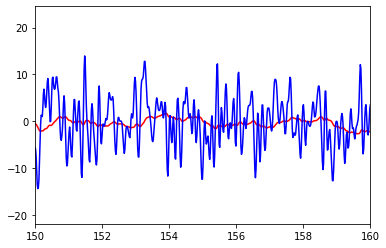

In [6]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'b-')
plt.xlim(150,160)

In [7]:
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
t_cor

0.674876178537432

In [8]:
realr, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber], np.append(0,T))
realr[np.where(realr >= 2)] = 2
np.unique(realr)

array([0, 1, 2], dtype=int64)

In [9]:
##response
# Model one: simple estimation
window = [-1,1] # second
Ux_peaktime =[]
Uv_peaktime = []
Syn_peaktime = []
Rdn_peaktime = []
Ux_peakH =[]
Uv_peakH = []
Syn_peakH = []
Rdn_peakH = []
deltaTs = np.arange(0,1.2,0.02)
for deltaT in deltaTs:
    r = x+v*deltaT
    #assign states
    model = 2
    rstate = Fake_Spike_Activation_function(realr, r, model)
    #rstate = np.random.poisson(rstate)
    rstate = rstate.astype(int)
    xstate,edge = EqualState(x, 6)
    vstate,edge = EqualState(v, 6)
    #calculate information
    timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
    Ux = Information[('Beer','UIx')]
    Uv = Information[('Beer','UIv')]
    Syner = Information[('Beer','Syn')]
    Redun = Information[('Beer','Red')]
    #find peak
    Ux_peaktime.append( timeshift[int(np.mean(np.where(Ux == max(Ux))))])
    Uv_peaktime.append( timeshift[int(np.mean(np.where(Uv == max(Uv))))])
    Syn_peaktime.append( timeshift[int(np.mean(np.where(Syner == max(Syner))))])
    Rdn_peaktime.append( timeshift[int(np.mean(np.where(Redun == max(Redun))))])
    Ux_peakH.append( max(Ux))
    Uv_peakH.append( max(Uv))
    Syn_peakH.append( max(Syner))
    Rdn_peakH.append( max(Redun))

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anac

In [10]:
Ux_peaktime = np.array(Ux_peaktime)
Uv_peaktime = np.array(Uv_peaktime)
Syn_peaktime = np.array(Syn_peaktime)
Rdn_peaktime = np.array(Rdn_peaktime)
Ux_peakH = np.array(Ux_peakH)
Uv_peakH = np.array(Uv_peakH)
Syn_peakH = np.array(Syn_peakH)
Rdn_peakH = np.array(Rdn_peakH)

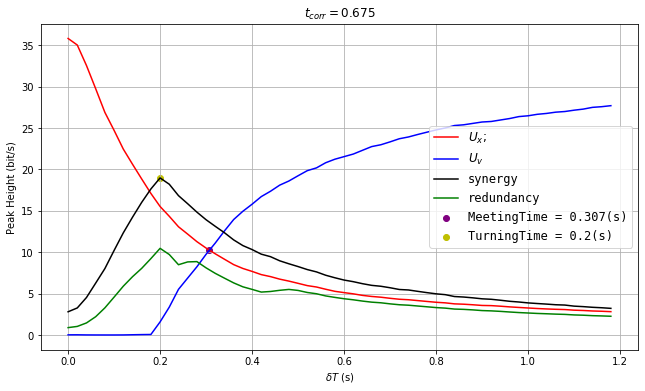

In [11]:
xvMeatingTime = np.interp(1,  Uv_peakH/Ux_peakH, deltaTs)
xvMeatingHeight = np.interp(xvMeatingTime,  deltaTs, Ux_peakH)
plt.plot(deltaTs,Ux_peakH, 'r-')
plt.plot(deltaTs,Uv_peakH, 'b-')
plt.plot(deltaTs,Syn_peakH, 'k-')
plt.plot(deltaTs,Rdn_peakH, 'g-')
plt.scatter(xvMeatingTime, xvMeatingHeight, c = 'purple')
TurningTime = np.interp(np.where(Syn_peakH == max(Syn_peakH))[0][0],  np.arange(len(deltaTs)), deltaTs)
plt.scatter(TurningTime , max(Syn_peakH), c = 'y')
plt.title(r'$t_{corr} = $'+ str(round(t_cor,3)))
plt.xlabel(r'$\delta T$ (s)')
plt.ylabel(r'Peak Height (bit/s)')
plt.grid(True)
plt.gcf().set_size_inches(10.7, 6)
plt.legend((r'$U_x;$', r'$U_v$', 'synergy', 'redundancy', 'MeetingTime = '+str(round(xvMeatingTime,3))+'(s)', 'TurningTime = '+str(round(TurningTime,3))+'(s)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
figure = plt.gcf()

In [12]:
save_folder = 'C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\analysis result\\DeltaT vs Tau\\'
save_folder = 'C:\\Users\\llinc\\GitHub\\python code\\analysis result\\DeltaT vs Tau\\'
name = 'PeakHeights_Fc='+str(Fc)+'.tif'
figure.savefig(save_folder+name)

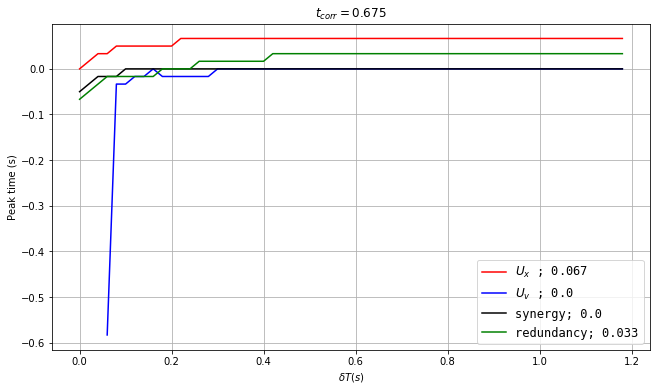

In [13]:
plt.plot(deltaTs,Ux_peaktime, 'r-')
plt.plot(deltaTs[3:],Uv_peaktime[3:], 'b-')
plt.plot(deltaTs,Syn_peaktime, 'k-')
plt.plot(deltaTs,Rdn_peaktime, 'g-')
plt.title(r'$t_{corr} = $'+ str(round(t_cor,3)))
plt.xlabel(r'$\delta T (s)$')
plt.ylabel('Peak time (s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$ ; '+str(round(Ux_peaktime[-1],3)), r'$U_v$ ; '+str(round(Uv_peaktime[-1],3)), 'synergy; '+str(round(Syn_peaktime[-1],3)), 'redundancy; '+str(round(Rdn_peaktime[-1],3))), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.grid(True)
figure = plt.gcf()

In [14]:
save_folder = 'C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\analysis result\\DeltaT vs Tau\\'
save_folder = 'C:\\Users\\llinc\\GitHub\\python code\\analysis result\\DeltaT vs Tau\\'
name = 'PeakTimes_Fc='+str(Fc)+'.tif'
figure.savefig(save_folder+name)